In [ ]:
# Mashup of stuff from
# https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb
# https://github.com/alexis-jacq/Pytorch-Tutorials/blob/master/Neural_Style.ipynb
# https://arxiv.org/abs/1508.06576

In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
dtype = torch.cuda.FloatTensor

In [3]:
%matplotlib inline

In [36]:
imsize = 512
loader = transforms.Compose([
    transforms.Scale((imsize, imsize)),
    transforms.ToTensor(),
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # need a fake batch dim for nn
    image = image.unsqueeze(0)
    return image

In [37]:
# display the images
unloader = transforms.Compose([
    transforms.ToPILImage(),
])

def imshow(tensor):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(image)

In [38]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

In [39]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size() # a = batch size, b = K (num maps), c * d = N (size of map)
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        # renormalize
        return G.div(a * b * c * d)

In [40]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

In [41]:
cnn = models.vgg19(pretrained=True).features

In [42]:
for param in cnn.parameters():
    param.requires_grad = False

In [43]:
cnn = cnn.cuda()

In [45]:
def create_model(content, style, cnn, content_weight=1.0, style_weight=10000.0):
    content_layers = ["r42"]
    style_layers = ["r11", "r21", "r31", "r41", "r51"]

    content_losses = []
    style_losses = []

    model = nn.Sequential().cuda()
    gram = GramMatrix().cuda()

    i = 1
    j = 0
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            j += 1
            name = "c{}{}".format(i,j)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = "r{}{}".format(i, j)
            model.add_module(name, layer)

            if name in content_layers:
                target = model.forward(content).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_{}_{}".format(i, j), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model.forward(style).clone()
                target_feature_gram = gram.forward(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_{}_{}".format(i, j), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.MaxPool2d):
            name = "p{}".format(i)
            avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module(name, avgpool)
            i += 1
            j = 0
    return model, style_losses, content_losses

In [46]:
def run_model(model, style_losses, content_losses, input_image, num_iter):
    optimizer = optim.LBFGS([input_image])
    run = [0]
    while run[0] <= num_iter:
        def closure():
            #input_image.data.clamp_(0, 1)
            optimizer.zero_grad()
            model.forward(input_image)
            style_score = 0
            content_score = 0
            for i, sl in enumerate(style_losses):
                style_score += sl.loss
            for i, cl in enumerate(content_losses):
                content_score += cl.loss
            run[0] += 1
            if run[0] % 50 == 0:
                print ("run {} : {}, {}".format(run, style_score.data[0], content_score.data[0]))
            loss = content_score + style_score
            loss.backward()
            return loss
        optimizer.step(closure)
    return input_image

In [47]:
# chose your files here
style_file = "./neural_style/vangogh_starry_night.jpg"
content_file = "./neural_style/Tuebingen_Neckarfront.jpg"

In [48]:
style = image_loader(style_file).type(dtype)
content = image_loader(content_file).type(dtype)
# play around with the content and style weight to get the desired tradeoff between style and content preservation
model, style_losses, content_losses = create_model(
    content,style, cnn
)
input_im = image_loader(content_file).type(dtype)
input_im = nn.Parameter(input_im.data)
result = run_model(model, style_losses, content_losses, input_im, num_iter=300)

run [50] : 0.10079220682382584, 0.2585560977458954
run [100] : 0.05952965468168259, 0.22923493385314941
run [150] : 0.04759656637907028, 0.2176869511604309
run [200] : 0.04353019595146179, 0.21145620942115784
run [250] : 0.042197830975055695, 0.20754477381706238
run [300] : 0.041446007788181305, 0.20512822270393372


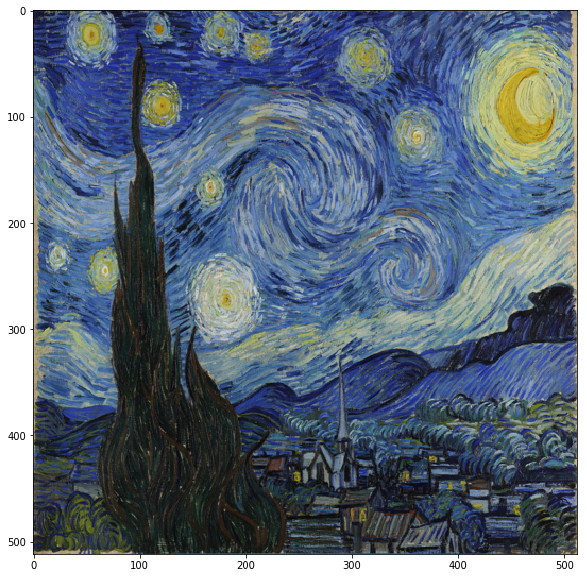

In [49]:
imshow(style.data)

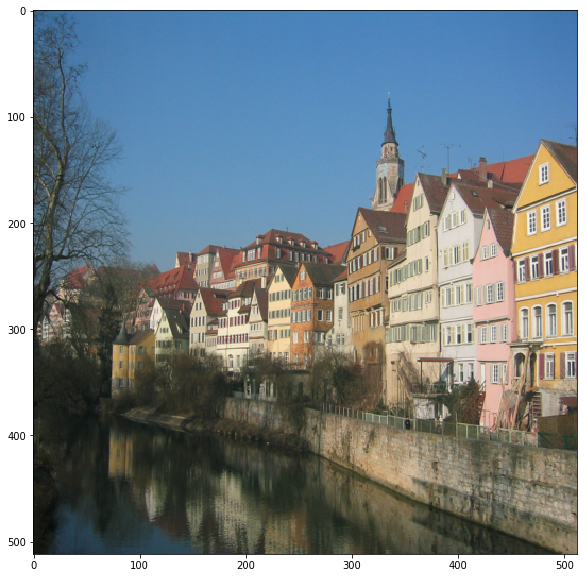

In [50]:
imshow(content.data)

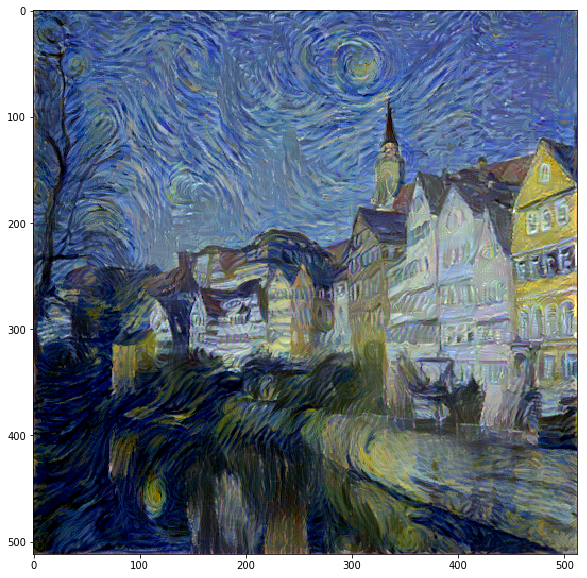

In [51]:
imshow(result.data.clamp_(0,1))